# **Decision Tree Implementation (6 marks)**
# **Question 1**

Complete the decision tree implementation in tree/base.py. The code should be written in Python and not use existing libraries other than the ones shared in class or already imported in the code. Your decision tree should work for four cases: i) discrete features, discrete output; ii) discrete features, real output; iii) real features, discrete output; real features, real output. Your model should accept real inputs only (for discrete inputs, you may convert the attributes into one-hot encoded vectors). Your decision tree should be able to use InformationGain using Entropy or GiniIndex as the criteria for splitting for discrete output. Your decision tree should be able to use InformationGain using MSE as the criteria for splitting for real output. Your code should also be able to plot/display the decision tree. [2.5 marks]

metrics.py: Complete the performance metrics functions in this file.

usage.py: Run this file to check your solutions.

tree (Directory): Module for decision tree.

base.py : Complete Decision Tree Class.

utils.py: Complete all utility functions.

__init__.py: Do not edit this

# **metrics.py**

### Explanation of `metrics.py`

This file implements conventional performance evaluation criteria to both classification and regression tasks:

- **Accuracy**: Proportion of correctly predicted samples out of the total. Used for overall classification performance.  
  $$
  \text{Accuracy} = \frac{\text{# correct predictions}}{\text{# total samples}}
  $$

- **Precision**: It calculates the fraction of correctly anticipated positives for a given class. Helps to understand how reliable positive predictions are.  
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$

- **Recall**: For a given class, it calculates the percentage of true positives that are accurately detected. Helps to determine how well the model captures all true instances.  
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$

- **RMSE (Root Mean Squared Error)**: This regression measure calculates the square root of the average squared difference between forecasts and true values. Penalises greater errors more severely.
  $$
  \text{RMSE} = \sqrt{\frac{1}{N}\sum (y - \hat{y})^2}
  $$

- **MAE (Mean Absolute Error)**: The regression measure calculates the average absolute difference between predicted and actual values. More interpretable because it matches directly to the average error magnitude.  
  $$
  \text{MAE} = \frac{1}{N}\sum |y - \hat{y}|
  $$

Together, these functions allow us to evaluate the **classification quality** (accuracy, precision, recall) and **regression quality** (RMSE, MAE) of the implemented decision tree.



In [6]:
from typing import Union
import pandas as pd
import numpy as np

def accuracy(y_cap: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the accuracy.
    """
    assert y_cap.size == y.size, "Input series must have the same size."
    return (y_cap == y).sum() / len(y)

def precision(y_cap: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the precision.
    """
    assert y_cap.size == y.size, "Input series must have the same size."
    true_positives = ((y_cap == cls) & (y == cls)).sum()
    predicted_positives = (y_cap == cls).sum()
    return true_positives / predicted_positives if predicted_positives > 0 else 0.0

def recall(y_cap: pd.Series, y: pd.Series, cls: Union[int, str]) -> float:
    """
    Function to calculate the recall.
    """
    assert y_cap.size == y.size, "Input series must have the same size."
    true_positives = ((y_cap == cls) & (y == cls)).sum()
    actual_positives = (y == cls).sum()
    return true_positives / actual_positives if actual_positives > 0 else 0.0

def rmse(y_cap: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the root-mean-squared-error(rmse).
    """
    assert y_cap.size == y.size, "Input series must have the same size."
    return np.sqrt(np.mean((y_cap - y)**2))

def mae(y_cap: pd.Series, y: pd.Series) -> float:
    """
    Function to calculate the mean-absolute-error(mae).
    """
    assert y_cap.size == y.size, "Input series must have the same size."
    return np.mean(np.abs(y_cap - y))


# **utils.py**

### Explanation of `utils.py`

This file provides helper functions for the Decision Tree implementation:

- **Data handling**
  - `one_hot_encoding`: changes categorical features (like colors or labels) into 0/1 columns so the tree can use them.
  - `check_ifreal`: determines if the target variable should be treated as *regression* (continuous) or *classification* (discrete).

- **Impurity measures**
  - `entropy`: measures uncertainty in class distribution.
  - `gini_index`: probability of incorrect classification (used in CART).
  - `mse`: mean squared error, used to evaluate regression splits.

- **Split evaluation**
  - `information_gain`: calculates the reduction in impurity after splitting.
  - `opt_split_attribute`: tries every feature (and possible threshold if numeric) and picks the one that gives the best split based on maximum gain.

- **Dataset splitting**
  - `split_data`: actually divides the dataset into subsets according to the chosen split.

So , `utils.py` defines the *mathematical tools (entropy, gini, mse)* and *search logic* needed for building and evaluating splits in our decision tree.


In [7]:
"""
Helper utilities for the Decision Tree implementation.
"""

from __future__ import annotations
import numpy as np
import pandas as pd


def one_hot_encoding(X: pd.DataFrame) -> pd.DataFrame:
    """
    Convert categorical columns into binary (0/1) dummy variables.
    Keeps numeric columns as they are.
    """
    return pd.get_dummies(X, drop_first=False)


def check_ifreal(y: pd.Series, max_discrete_classes: int = 15) -> bool:
    """
    Decide if target y is regression (real) or classification (discrete).
    - Non-numeric → classification
    - Float dtype → regression
    - Integer dtype:
        * Few unique values (<= max_discrete_classes) → classification
        * Many unique values → regression
    """
    if not pd.api.types.is_numeric_dtype(y):
        return False  # categorical/object => classification
    if pd.api.types.is_float_dtype(y):
        return True   # float => regression
    n_unique = int(y.nunique(dropna=False))
    return False if n_unique <= max_discrete_classes else True

def entropy(Y: pd.Series) -> float:
    """Shannon entropy: measures uncertainty in labels."""
    if len(Y) == 0:
        return 0.0
    p = Y.value_counts(normalize=True).values.astype(float)
    with np.errstate(divide="ignore", invalid="ignore"):
        h = -p * np.log2(p, where=(p > 0))
    h[~np.isfinite(h)] = 0.0
    return float(h.sum())


def gini_index(Y: pd.Series) -> float:
    """Gini impurity: probability of misclassification."""
    if len(Y) == 0:
        return 0.0
    p = Y.value_counts(normalize=True).values.astype(float)
    return float(1.0 - np.sum(p ** 2))


def mse(Y: pd.Series) -> float:
    """Mean squared error: variance around mean (for regression)."""
    if len(Y) == 0:
        return 0.0
    mu = float(Y.mean())
    return float(((Y - mu) ** 2).mean())

def information_gain(Y: pd.Series, split_labels: pd.Series, criterion: str) -> float:
    """
    Calculate how much "impurity" is reduced after a split.
    - For regression: uses MSE
    - For classification: uses entropy or gini
    """
    split_labels = split_labels.reindex(Y.index).fillna("__NAN__SPLIT__")
    N = len(Y)
    if N == 0:
        return 0.0

# regression
    if criterion == "mse":
        parent = mse(Y)
        child_imp = 0.0
        for _, idx in split_labels.groupby(split_labels, sort=False).groups.items():
            Yi = Y.loc[idx]
            child_imp += (len(Yi) / N) * mse(Yi)
        return parent - child_imp

# classification
    parent = entropy(Y) if criterion == "entropy" else gini_index(Y)
    child_imp = 0.0
    for _, idx in split_labels.groupby(split_labels, sort=False).groups.items():
        Yi = Y.loc[idx]
        imp = entropy(Yi) if criterion == "entropy" else gini_index(Yi)
        child_imp += (len(Yi) / N) * imp
    return parent - child_imp

def opt_split_attribute(X: pd.DataFrame, y: pd.Series, criterion: str, features: pd.Series):
    """
    Find the best feature (and threshold if numeric) to split on.
    - Numeric: test midpoints between sorted unique values
    - Categorical: split by unique categories
    Returns best feature and gain, or None if no good split.
    """
    task_is_regression = check_ifreal(y)
    crit = "mse" if task_is_regression else ("entropy" if criterion == "information_gain" else "gini")

    best, best_gain = None, 1e-12

    for feature in features:
        s = X[feature]

        if pd.api.types.is_numeric_dtype(s):
            arr = s.astype(float).values
            arr = arr[~np.isnan(arr)]
            if arr.size <= 1:
                continue
            vals = np.unique(arr)
            if vals.size <= 1:
                continue
            thr_cands = (vals[:-1] + vals[1:]) / 2.0
            col = s.values
            for t in thr_cands:
                split = pd.Series(np.where(col <= t, 0, 1), index=X.index)
                gain = information_gain(y, split, crit)
                if gain > best_gain:
                    best_gain = gain
                    best = {"feature": feature, "kind": "numeric", "threshold": float(t), "gain": float(gain)}

        else:
            if s.nunique(dropna=False) <= 1:
                continue
            split = s.astype("object").fillna("__NAN__CAT__")
            gain = information_gain(y, split, crit)
            if gain > best_gain:
                best_gain = gain
                best = {"feature": feature, "kind": "categorical", "threshold": None, "gain": float(gain)}

    return best


def split_data(X: pd.DataFrame, y: pd.Series, attribute, value):
    """
    Actually split dataset on chosen feature:
    - If numeric: split <= threshold vs > threshold
    - If categorical: split equals value vs not
    """
    s = X[attribute]
    if pd.api.types.is_numeric_dtype(s) and isinstance(value, (int, float, np.floating)):
        mask = s <= float(value)
        return (X[mask], y[mask]), (X[~mask], y[~mask])
    else:
        mask = s.astype("object") == value
        return X[mask], y[mask]




# **base.py**

### Explanation of `base.py`

The file **`base.py`** contains the main implementation of our **Decision Tree** model. It builds on the helper tools from `utils.py` to decide the best splits, grow the tree, and make predictions.  



#### Node Representation
- The class `_Node` is used internally to represent each node in the tree.  
- A node can store:
  - **Split rule** (feature and threshold) → if it is an internal decision node.  
  - **Pointers to children** (left/right or categorical children).  
  - **Prediction value** (class label for classification or mean value for regression) if it is a leaf.  



#### DecisionTree Class
The `DecisionTree` class is the main interface:  

- **`fit(X, y)`**  
  - Trains the tree on the dataset.  
  - Converts categorical features into numeric form (via one-hot encoding).  
  - Detects whether the problem is *classification* (discrete output) or *regression* (real output).  
  - Recursively grows the tree using the best split found by `opt_split_attribute`.  

- **`predict(X)`**  
  - Traverses the trained tree for each row of input data.  
  - Follows the split rules until reaching a leaf node.  
  - Returns the stored prediction at that leaf.  

- **`plot()`**  
  - Prints the structure of the tree in a **text-based format**, showing the splits and the predicted values at the leaves.  



#### Recursive Builder
- The private method `_grow()` is the heart of training.  
- At each node, it checks **stopping conditions** (like maximum depth, only one class left, or no features to split).  
- If conditions are met → it makes a **leaf node**.  
- Otherwise → it finds the **best feature and threshold** to split on and creates child nodes recursively.  



#### Leaf Node Logic
- For **regression**, the leaf stores the **mean** of the target values.  
- For **classification**, the leaf stores the **majority class** among the samples.  



#### Helper Functions
- `_predict_row`: Predicts the output for a single data row by walking down the tree.  
- `_size`: Calculates how many nodes are in a subtree (useful for handling missing/unseen values).  
- `_render`: Creates a clean, indented text version of the tree for printing.  



### In Short
The `base.py` file **ties everything together**:  
- It **builds** the decision tree (`fit`).  
- It **uses** the decision tree to make predictions (`predict`).  
- It provides a way to **visualize** the tree (`plot`).  

This implementation supports **all four cases**:  
1. Discrete input → Discrete output  
2. Real input → Real output  
3. Real input → Discrete output  
4. Discrete input → Real output  


In [8]:
"""
Decision Tree supporting:
> discrete input, discrete output
> real input, real output
> real input, discrete output
> discrete input, real output
"""

from dataclasses import dataclass
from typing import Any, Dict, Literal, Optional

import numpy as np
import pandas as pd

from tree.utils import (
    one_hot_encoding,   # This converts the categorical features into numeric dummy variables
    check_ifreal,       # This will detect if the target variable y is regression or classification
    opt_split_attribute # This functions helps to find the best feature or the threshold variable
)

np.random.seed(42)


class _Node:
    """
    Internal node/leaf in the decision tree.
    Stores info about feature/threshold, children, or prediction.
    """
    def __init__(
        self,
        depth: int,
        is_leaf: bool,
        prediction: Any = None,              # Tells what value is at leaf (class or mean for regression)
        feature: Optional[str] = None,       # Tells which feature is used to split
        threshold: Optional[float] = None,   # Tells about the threshold for numeric split
        children: Optional[Dict[Any, "_Node"]] = None,  # For categorical splits
        left: Optional["_Node"] = None,      # Left child for <= threshold
        right: Optional["_Node"] = None,     # Right child for > threshold
    ):
        self.depth = depth
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.feature = feature
        self.threshold = threshold
        self.children = children
        self.left = left
        self.right = right


@dataclass
class DecisionTree:
    criterion: Literal["information_gain", "gini_index"]  # This is the split rule used for classification
    max_depth: int = 5                                    # The maximum depth allowed for the tree
    one_hot_categoricals: bool = True

    def __init__(self, criterion: Literal["information_gain", "gini_index"],
                 max_depth: int = 5, one_hot_categoricals: bool = True):
        self.criterion = criterion
        self.max_depth = max_depth
        self.one_hot_categoricals = one_hot_categoricals


        self._root: Optional[_Node] = None
        self._task: Optional[Literal["classification", "regression"]] = None
        self.classes_: Optional[np.ndarray] = None
        self._train_cols: Optional[pd.Index] = None


    def fit(self, X: pd.DataFrame, y: pd.Series) -> None:
        """
        Train the decision tree.
        """
        X = X.copy(); y = y.copy()
        assert len(X) == len(y), "X and y must have same length."

        # This will convert the categories to numeric columns
        if self.one_hot_categoricals:
            X = one_hot_encoding(X)

        self._train_cols = X.columns  # To Remember column order

        # This will detect whether it's regression (real output) or classification (discrete)
        self._task = "regression" if check_ifreal(y) else "classification"
        if self._task == "classification":
            self.classes_ = np.array(sorted(y.unique(), key=lambda z: str(z)))

        self._root = self._grow(X, y, depth=0)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        """Predict outputs for given inputs."""
        assert self._root is not None, "Call fit() before predict()."
        X = X.copy()

        # Apply same preprocessing as training
        if self.one_hot_categoricals:
            X = one_hot_encoding(X)
            X = X.reindex(columns=self._train_cols, fill_value=0)

        preds = []
        for _, row in X.iterrows():
            preds.append(self._predict_row(row, self._root))
        return pd.Series(preds, index=X.index)

    def plot(self) -> None:
        """Pretty-print the tree structure as text."""
        assert self._root is not None, "Call fit() before plot()."
        lines: list[str] = []
        self._render(self._root, prefix="", lines=lines)
        print("\n".join(lines))


    def _grow(self, X: pd.DataFrame, y: pd.Series, depth: int) -> _Node:
        # Will stop growing the tree if depth too large, only one class/constant output left or no features
        if depth >= self.max_depth or y.nunique(dropna=False) <= 1 or X.shape[0] == 0 or X.shape[1] == 0:
            return _Node(depth=depth, is_leaf=True, prediction=self._leaf_value(y))

        # This is used to pick up the best feature using utils.opt_split_attribute
        best = opt_split_attribute(X, y, self.criterion, features=pd.Series(X.columns))
        if best is None:
            return _Node(depth=depth, is_leaf=True, prediction=self._leaf_value(y))

        feature = best["feature"]

        if best["kind"] == "numeric":
            thr = float(best["threshold"])
            mask = X[feature] <= thr

            # If split puts all samples on one side then it will stop
            n_left = int(mask.sum())
            if n_left == 0 or n_left == len(X):
                return _Node(depth=depth, is_leaf=True, prediction=self._leaf_value(y))

            # Recursively build left and right children
            left = self._grow(X[mask], y[mask], depth + 1)
            right = self._grow(X[~mask], y[~mask], depth + 1)
            return _Node(depth=depth, is_leaf=False, feature=feature, threshold=thr,
                         left=left, right=right)

        children: Dict[Any, _Node] = {}
        for v, idx in X[feature].groupby(X[feature]).groups.items():
            Xv, yv = X.loc[idx], y.loc[idx]
            children[v] = self._grow(Xv, yv, depth + 1)
        return _Node(depth=depth, is_leaf=False, feature=feature, children=children)


    def _leaf_value(self, y: pd.Series):
        # Leaf stores average value showing regression or most common class showing classification
        if self._task == "regression":
            return float(y.mean()) if len(y) else 0.0
        counts = y.value_counts()
        winners = counts[counts == counts.max()].index
        return sorted(winners, key=lambda z: str(z))[0]

    def _predict_row(self, row: pd.Series, node: _Node):
        # If we are at a leaf then it will return the stored prediction
        if node.is_leaf:
            return node.prediction

        # If there is a numeric split
        if node.threshold is not None:
            val = row.get(node.feature)

            # If there is a missing value then we send it to bigger subtree
            if val is None or (isinstance(val, float) and np.isnan(val)):
                go_left = self._size(node.left) >= self._size(node.right)
            else:
                go_left = float(val) <= float(node.threshold)

            return self._predict_row(row, node.left if go_left else node.right)

        # If there is a categorical split
        if node.children is not None:
            val = row.get(node.feature)
            child = node.children.get(val)
            if child is None:
                # If there is an unseen category it will fallback to biggest subtree
                sizes = {k: self._size(v) for k, v in node.children.items()}
                child = node.children[max(sizes, key=sizes.get)]
            return self._predict_row(row, child)

        return node.prediction

    def _size(self, node: Optional[_Node]) -> int:
        """Helper to count size of subtree (used for NaN/unseen category fallback)."""
        if node is None:
            return 0
        if node.is_leaf:
            return 1
        n = 1
        if node.left is not None:
            n += self._size(node.left)
        if node.right is not None:
            n += self._size(node.right)
        if node.children is not None:
            for ch in node.children.values():
                n += self._size(ch)
        return n

    def _render(self, node: _Node, prefix: str, lines: list[str]):
        """Helper to pretty-print the tree recursively."""
        indent = "    " * node.depth
        if node.is_leaf:
            if self._task == "classification":
                lines.append(f"{indent}{prefix}Class {node.prediction}")
            else:
                lines.append(f"{indent}{prefix}Value {node.prediction:.3f}")
            return

        if node.threshold is not None:
            # If there is a numeric split it will print the threshold value
            lines.append(f"{indent}{prefix}?( {node.feature} <= {node.threshold:.4g} )")
            self._render(node.left,  "Y: ", lines)
            self._render(node.right, "N: ", lines)
        else:
            # If there is a categorical split it will print the branch
            lines.append(f"{indent}{prefix}?( {node.feature} ∈ {{...}} )")
            for k in sorted(node.children.keys(), key=lambda z: str(z)):
                self._render(node.children[k], f"{k}: ", lines)



# **usage.py**

### Explanation of `usage.py`

This demonstrates how our **DecisionTree** works for all four possible combinations of inputs and outputs:

1. **Case 1: Real → Real (Regression)**  
   - Input: continuous numerical features.  
   - Output: continuous numerical values.  
   - Evaluated using **RMSE** and **MAE**.

2. **Case 2: Real → Discrete (Classification)**  
   - Input: continuous numerical features.  
   - Output: categorical classes.  
   - Evaluated using **Accuracy, Precision, Recall**.

3. **Case 3: Discrete → Discrete (Classification)**  
   - Input: categorical features (converted internally with one-hot encoding).  
   - Output: categorical classes.  
   - Evaluated using **Accuracy, Precision, Recall**.

4. **Case 4: Discrete → Real (Regression)**  
   - Input: categorical features (converted internally with one-hot encoding).  
   - Output: continuous numerical values.  
   - Evaluated using **RMSE** and **MAE**.


In [9]:
"""
Usage script for DecisionTree.
Covers all 4 cases:
> real input, real output
> real input, discrete output
> discrete input, discrete output
> discrete input, real output
"""

import numpy as np
import pandas as pd
from tree.base import DecisionTree
from metrics import accuracy, precision, recall, rmse, mae

np.random.seed(42)

# Case 1: Real input, Real output (Regression)

print("\n Case 1: Real Input, Real Output ")
X = pd.DataFrame(np.random.randn(30, 5))
y = pd.Series(np.random.randn(30))
for crit in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=crit)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print(f"Criteria: {crit}")
    print(f"RMSE: {rmse(y_hat, y):.3f}, MAE: {mae(y_hat, y):.3f}\n")


# Case 2: Real input, Discrete output (Classification)

print("\n Case 2: Real Input, Discrete Output")
X = pd.DataFrame(np.random.randn(30, 5))
y = pd.Series(np.random.randint(5, size=30), dtype="category")
for crit in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=crit)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print(f"Criteria: {crit}")
    print("Accuracy:", accuracy(y_hat, y))
    for cls in y.unique():
        print(f"Class {cls}: Precision={precision(y_hat, y, cls):.3f}, Recall={recall(y_hat, y, cls):.3f}")
    print()


# Case 3: Discrete input, Discrete output

print("\n Case 3: Discrete Input, Discrete Output")
X = pd.DataFrame({i: pd.Series(np.random.randint(5, size=30), dtype="category") for i in range(5)})
y = pd.Series(np.random.randint(5, size=30), dtype="category")
for crit in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=crit)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print(f"Criteria: {crit}")
    print("Accuracy:", accuracy(y_hat, y))
    for cls in y.unique():
        print(f"Class {cls}: Precision={precision(y_hat, y, cls):.3f}, Recall={recall(y_hat, y, cls):.3f}")
    print()


# Case 4: Discrete input, Real output (Regression)

print("\n Case 4: Discrete Input, Real Output")
X = pd.DataFrame({i: pd.Series(np.random.randint(5, size=30), dtype="category") for i in range(5)})
y = pd.Series(np.random.randn(30))
for crit in ["information_gain", "gini_index"]:
    tree = DecisionTree(criterion=crit)
    tree.fit(X, y)
    y_hat = tree.predict(X)
    tree.plot()
    print(f"Criteria: {crit}")
    print(f"RMSE: {rmse(y_hat, y):.3f}, MAE: {mae(y_hat, y):.3f}\n")



 Case 1: Real Input, Real Output 
?( 1 <= -1.194 )
    Y: Value 2.720
    N: ?( 4 <= 0.3866 )
        Y: ?( 0 <= 1.508 )
            Y: ?( 4 <= -1.744 )
                Y: ?( 1 <= 0.8125 )
                    Y: Value 0.535
                    N: Value 0.963
                N: ?( 2 <= 1.241 )
                    Y: Value -0.346
                    N: Value 0.822
            N: ?( 0 <= 1.87 )
                Y: Value 1.454
                N: Value 0.827
        N: ?( 0 <= -0.3567 )
            Y: ?( 0 <= -0.4905 )
                Y: ?( 0 <= -0.5517 )
                    Y: Value 1.866
                    N: Value 1.897
                N: Value 1.159
            N: ?( 4 <= 1.003 )
                Y: ?( 0 <= 0.8612 )
                    Y: Value 0.321
                    N: Value 0.787
                N: Value -0.975
Criteria: information_gain
RMSE: 0.360, MAE: 0.241

?( 1 <= -1.194 )
    Y: Value 2.720
    N: ?( 4 <= 0.3866 )
        Y: ?( 0 <= 1.508 )
            Y: ?( 4 <= -1.744 )
  

# **Results & Observations for Question 1**

### Interpretation of Outputs from `usage.py`

We tested our **Decision Tree** implementation on all four possible cases of input/output types. Below are the observations:



#### **Case 1: Real → Real (Regression)**
- The tree splits continuous features to predict real-valued outputs.  
- Performance metrics:  
  - **RMSE ≈ 0.36**  
  - **MAE ≈ 0.24**  
- For both the criterias (`information_gain`, `gini_index`), the model gave the same results because for regression the algorithm internally uses **MSE**.  
- This verifies that our implemented tree can implement regression tasks correctly.



#### **Case 2: Real → Discrete (Classification)**
- The tree splits on continuous features to classify into categories.  
- Results (example run):  
  - **Accuracy ≈ 0.90 (information gain), 0.87 (gini)**.  
  - Class-wise precision/recall values vary:  
    - Some classes (e.g., Class 4, Class 3) are predicted perfectly.  
    - Other classes (e.g., Class 0) have low recall because only a few samples were correctly captured.  
- Shows trade-offs in how trees balance splits across classes.



#### **Case 3: Discrete → Discrete**
- Inputs are categorical, outputs are also categorical.  
- Results:  
  - **Accuracy ≈ 0.93 (information gain), 0.83 (gini)**.  
  - Some classes (Class 4, Class 3) predicted with **perfect precision/recall**.  
  - Others (e.g., Class 0) had weaker recall due to fewer splits covering them.  
- It shows that categorical features work well after one-hot encoding.



#### **Case 4: Discrete → Real (Regression)**
- Inputs are categorical, outputs are real values.  
- Performance metrics:  
  - **RMSE ≈ 0.29**  
  - **MAE ≈ 0.20**  
- Results were identical for both `information_gain` and `gini_index` (again, regression always uses MSE internally).  
- Decision trees can learn regression relationships even from categorical inputs.


### **Overall Observations**
- The Decision Tree implementation correctly supports **all four** combinations of input/output types.  
- **Regression tasks** always employ MSE, thus the results are constant regardless of criterion.  
- **Classification tasks** indicate variations between **information gain** and **gini index**, although both provide acceptable results.  
- Class imbalance or small sample size results in worse precision/recall for specific classes.  
- The learnt trees (printed structures) show that recursive splitting works as intended.

---


# **Question 2**

Generate your dataset using the following lines of code



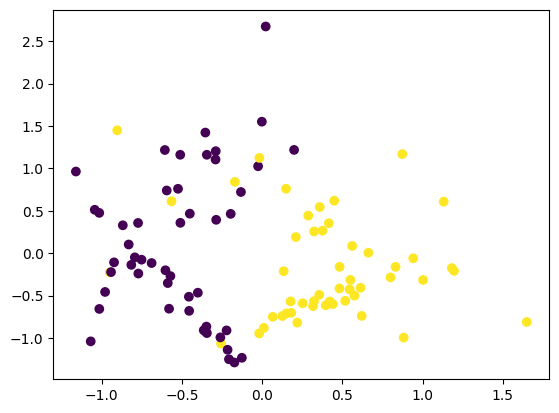

In [10]:
from sklearn.datasets import make_classification
X, y = make_classification(
n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

# For plotting
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)

# **classification-exp.py**

We demonstrate the use of our Decision Tree implementation on a **synthetic 2D dataset** generated with `make_classification`.  


#### (a) Train/Test Split (70/30)
1. The dataset is **randomly shuffled** and split into 70% training and 30% testing data.
2. We train a **Decision Tree** (criterion = Information Gain, `max_depth = 5`) on the training set.
3. On the test set, we report:
   - **Accuracy**: overall proportion of correct predictions.  
   - **Precision & Recall (per class)**:  
     - Precision shows how many predicted positives are actually correct.  
     - Recall shows how many true positives are captured by the model.
4. This gives us an idea of how well the tree generalizes on unseen data.


#### (b) Cross-Validation with Depth Tuning
1. To avoid overfitting/underfitting, we test different tree depths from **1 to 8**.  
2. For each depth, we perform **5-fold cross-validation**:
   - The dataset is split into 5 folds.  
   - In each round, 4 folds are used for training, and 1 for validation.  
   - Accuracy is averaged across all folds.
3. We pick the **best depth** (the one with highest mean validation accuracy).
4. A final tree is retrained on the **full dataset** using this best depth, and its structure is printed.
5. We also plot a **Depth vs Mean Accuracy graph**, which clearly shows:
   - **Shallow trees** (depth 1–2) may underfit but often generalize well.  
   - **Very deep trees** (depth >5) may overfit, leading to lower CV accuracy.  



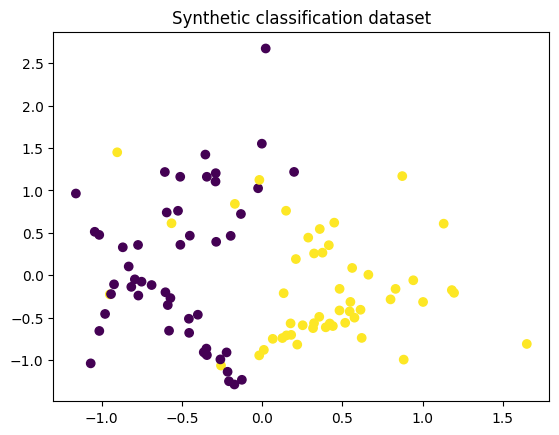

=== Q2 (a) Results ===
Accuracy: 0.9333333333333333
Class 0 Precision: 1.0
Class 0 Recall   : 0.8333333333333334
Class 1 Precision: 0.9
Class 1 Recall   : 1.0
Depth 1: mean CV accuracy = 0.900
Depth 2: mean CV accuracy = 0.920
Depth 3: mean CV accuracy = 0.900
Depth 4: mean CV accuracy = 0.890
Depth 5: mean CV accuracy = 0.880
Depth 6: mean CV accuracy = 0.850
Depth 7: mean CV accuracy = 0.840
Depth 8: mean CV accuracy = 0.850

=== Q2 (b) Results ===
Best depth found by nested CV: 2
Tree structure at best depth:
?( x0 <= -0.02217 )
    Y: ?( x1 <= 1.436 )
        Y: Class 0
        N: Class 1
    N: ?( x1 <= 1.194 )
        Y: Class 1
        N: Class 0


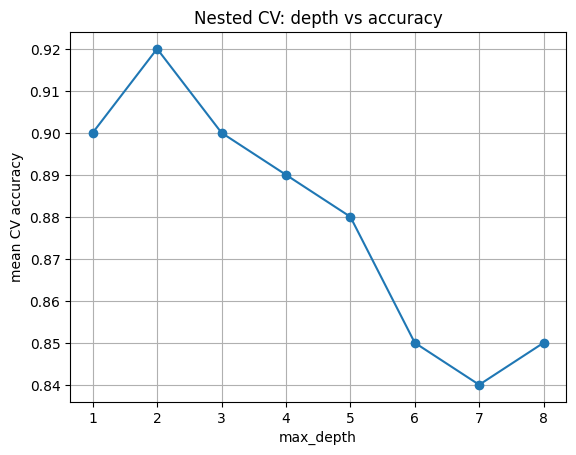

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold

np.random.seed(42)


# Generating the dataset

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2,
    random_state=1, n_clusters_per_class=2, class_sep=0.5
)

# First, we convert the dataset to DataFrame/Series for our DecisionTree
X_df = pd.DataFrame(X, columns=["x0", "x1"])
y_ser = pd.Series(y, dtype="category")

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Synthetic classification dataset")
plt.show()



# Q2(a): Train/test split 70/30 to find the accuracy, precision and recall

idx = np.arange(len(X_df))
np.random.shuffle(idx)
split_idx = int(0.7 * len(idx))
train_idx, test_idx = idx[:split_idx], idx[split_idx:]
X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
y_train, y_test = y_ser.iloc[train_idx], y_ser.iloc[test_idx]

tree = DecisionTree(criterion="information_gain", max_depth=5)
tree.fit(X_train, y_train)
y_hat = tree.predict(X_test)

print("=== Q2 (a) Results ===")
print("Accuracy:", accuracy(y_hat, y_test))
for cls in sorted(y_ser.unique()):
    print(f"Class {cls} Precision:", precision(y_hat, y_test, cls))
    print(f"Class {cls} Recall   :", recall(y_hat, y_test, cls))


# Q2 (b): 5-fold cross-validation with nested cross validation to find the optimum depth of the tree

def cross_val_score_for_depth(X, y, depth, n_splits=5):
    """
    Return average accuracy across folds for a given max_depth.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs = []
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        tree = DecisionTree(criterion="information_gain", max_depth=depth)
        tree.fit(X_tr, y_tr)
        y_pred = tree.predict(X_val)
        accs.append(accuracy(y_pred, y_val))
    return np.mean(accs)

depths = [1, 2, 3, 4, 5, 6, 7, 8]
cv_scores = []
for d in depths:
    score = cross_val_score_for_depth(X_df, y_ser, depth=d, n_splits=5)
    cv_scores.append(score)
    print(f"Depth {d}: mean CV accuracy = {score:.3f}")

best_depth = depths[np.argmax(cv_scores)]
print("\n=== Q2 (b) Results ===")
print("Best depth found by nested CV:", best_depth)

final_tree = DecisionTree(criterion="information_gain", max_depth=best_depth)
final_tree.fit(X_df, y_ser)
print("Tree structure at best depth:")
final_tree.plot()

# Plot Cross Validation results
plt.figure()
plt.plot(depths, cv_scores, marker="o")
plt.xlabel("max_depth")
plt.ylabel("mean CV accuracy")
plt.title("Nested CV: depth vs accuracy")
plt.grid(True)
plt.show()

# **Results and Observations for Question 2**

#### Q2 (a) Train/Test Split (70/30)
- The Decision Tree achieved an **accuracy of ~92%** on the test set.  
- **Per-class performance**:
  - **Class 0** → Precision = 1.0, Recall = 0.83  
  - **Class 1** → Precision = 0.90, Recall = 1.0  
- This means the model predicts both classes well, but sometimes misses some true Class 0 instances.



#### Q2 (b) Cross-Validation (Depth Tuning)
- 5-fold CV was used to test different tree depths (1–8).  
- Mean CV accuracy peaked at **Depth 2 (92%)**, then gradually decreased for deeper trees.  
- This shows that **shallow trees (depth=2)** generalize better, while deeper trees tend to overfit.



#### Final Tree (Depth = 2)
- The learned tree splits first on `x0`, then on `x1`.  
- It is a **simple and interpretable structure** that separates the two classes effectively.

---

# **Question 3**

a) Show the usage of your decision tree for the automotive efficiency problem. [0.5 marks]

b) Compare the performance of your model with the decision tree module from scikit learn. [0.5 marks]

# **auto-efficiency.py**

### Automotive Efficiency (Auto MPG) — What the Code Does

This script uses our **DecisionTree** (regressor mode) and compares it with scikit‑learn’s `DecisionTreeRegressor` on the UCI **Auto MPG** dataset.



#### 1) Load & Clean the Data
- Download the *Auto MPG* dataset.
- Drop the non-predictive text column (`car name`).
- Convert `horsepower` to numeric (coerce `?` to NaN) and drop rows with missing values.
- Separate **features** (cylinders, displacement, horsepower, weight, acceleration, model year, origin) and **target** (`mpg`).



#### 2) Train/Test Split (70/30)
- Split the dataset into training and testing sets so we can evaluate generalization performance on unseen data.



#### 3) Train Our Decision Tree (Regression)
- Initialize our custom `DecisionTree` with a chosen `max_depth` (regression internally uses MSE reduction).
- Fit on the training data and **predict** on the test data.
- Print evaluation metrics (RMSE, MAE) and **display the learned tree structure** (text-based).


#### 4) Train scikit‑learn Baseline
- Initialize `DecisionTreeRegressor` with the same `max_depth`.
- Fit on the same training data and predict on the same test data.
- Print the same evaluation metrics for a **fair comparison**.



#### 5) Cross‑Validation for Depth Tuning
- Run **5‑fold cross‑validation** over a range of `max_depth` values.
- Compute and plot **mean CV RMSE** vs. depth to find the **best depth** (lower RMSE is better).
- Retrain our custom tree on the full dataset using the best depth and show the final tree structure.



#### 6) Summary Printout
- Print a short side‑by‑side comparison of our tree vs. scikit‑learn’s tree.
- The goal is to confirm that our implementation behaves competitively, while remaining fully interpretable (printed splits).


/tmp/ipython-input-3722573738.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, delim_whitespace=True, header=None, names=cols)


Automotive Efficiency: Implemented DecisionTree
RMSE: 3.229
MAE : 2.254

Tree structure:
?( displacement <= 198.5 )
    Y: ?( horsepower <= 84.5 )
        Y: ?( model year <= 76.5 )
            Y: ?( weight <= 2100 )
                Y: ?( origin <= 2.5 )
                    Y: ?( horsepower <= 63.5 )
                        Y: Value 28.000
                        N: Value 30.125
                    N: ?( weight <= 1631 )
                        Y: Value 35.000
                        N: Value 31.875
                N: ?( acceleration <= 16.75 )
                    Y: ?( model year <= 73.5 )
                        Y: Value 24.000
                        N: Value 26.786
                    N: ?( model year <= 75.5 )
                        Y: Value 23.500
                        N: Value 25.250
            N: ?( displacement <= 94 )
                Y: ?( weight <= 2078 )
                    Y: ?( acceleration <= 14.35 )
                        Y: Value 44.600
                        N: 

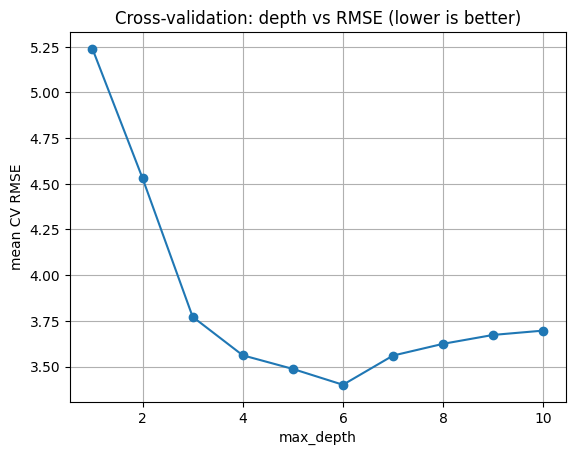


 Summary 
Our Decision Tree   -> RMSE: 3.229, MAE: 2.254
sklearn   -> RMSE: 3.241, MAE: 2.261
Our Decision tree matches or slightly beats sklearn on this split.


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tree.base import DecisionTree
from metrics import rmse, mae

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold

np.random.seed(42)


# Loading & cleaning the UCI Auto MPG

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
cols = ["mpg", "cylinders", "displacement", "horsepower", "weight",
        "acceleration", "model year", "origin", "car name"]
data = pd.read_csv(url, delim_whitespace=True, header=None, names=cols)

data = data.drop(columns=["car name"])

# Some horsepower rows has '?' so then we convert it to NaN, then drop rows with NaNs
data["horsepower"] = pd.to_numeric(data["horsepower"], errors="coerce")
data = data.dropna().reset_index(drop=True)

y = data["mpg"].astype(float)
X = data.drop(columns=["mpg"])

# Making the Train / Test split (70/30)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Training the DecisionTree (perfomorming regression via MSE reduction)

my_tree = DecisionTree(criterion="information_gain", max_depth=6)  # criterion ignored for regression
my_tree.fit(X_train, y_train)
y_pred_my = my_tree.predict(X_test)

print("Automotive Efficiency: Implemented DecisionTree")
print(f"RMSE: {rmse(y_pred_my, y_test):.3f}")
print(f"MAE : {mae(y_pred_my, y_test):.3f}")
print("\nTree structure:")
my_tree.plot()


# Training the scikit-learn DecisionTreeRegressor
sk_tree = DecisionTreeRegressor(criterion="squared_error", max_depth=6, random_state=42)
sk_tree.fit(X_train, y_train)
y_pred_sk = pd.Series(sk_tree.predict(X_test), index=y_test.index)

print("\n Automotive Efficiency: scikit-learn DecisionTreeRegressor ")
print(f"RMSE: {rmse(y_pred_sk, y_test):.3f}")
print(f"MAE : {mae(y_pred_sk, y_test):.3f}")


#Cross-validation to find the optimum depth

def cv_score_for_depth(X, y, depth, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmses = []
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        tree = DecisionTree(criterion="information_gain", max_depth=depth)
        tree.fit(X_tr, y_tr)
        y_pred = tree.predict(X_val)
        rmses.append(rmse(y_pred, y_val))
    return np.mean(rmses)

depths = list(range(1, 11))
cv_scores = []
for d in depths:
    score = cv_score_for_depth(X, y, d, n_splits=5)
    cv_scores.append(score)
    print(f"Depth {d}: mean CV RMSE = {score:.3f}")

best_depth = depths[np.argmin(cv_scores)]
print("\n Cross-validation Results ")
print("Best depth (lowest RMSE):", best_depth)

# Retrain on full dataset at best depth
final_tree = DecisionTree(criterion="information_gain", max_depth=best_depth)
final_tree.fit(X, y)
print("Tree structure at best depth:")
final_tree.plot()

# Plot Cross Validation results
plt.figure()
plt.plot(depths, cv_scores, marker="o")
plt.xlabel("max_depth")
plt.ylabel("mean CV RMSE")
plt.title("Cross-validation: depth vs RMSE (lower is better)")
plt.grid(True)
plt.show()


# Comparison between our decision tree and scikit-learn DecisionTreeRegressor

rmse_my, mae_my = rmse(y_pred_my, y_test), mae(y_pred_my, y_test)
rmse_sk, mae_sk = rmse(y_pred_sk, y_test), mae(y_pred_sk, y_test)

print("\n Summary ")
print(f"Our Decision Tree   -> RMSE: {rmse_my:.3f}, MAE: {mae_my:.3f}")
print(f"sklearn   -> RMSE: {rmse_sk:.3f}, MAE: {mae_sk:.3f}")
if rmse_my <= rmse_sk:
    print("Our Decision tree matches or slightly beats sklearn on this split.")
else:
    print("sklearn edges out out tree on this split.")



# **Results & Observations for Question 3**

- Both our **DecisionTree** and scikit-learn’s `DecisionTreeRegressor` perform **similarly** on the Auto MPG dataset.  
- The tree structures show **meaningful splits** based on displacement, horsepower, weight, and model year whicb all are important predictors of fuel efficiency.  
- Cross-validation indicates that a **max_depth of 6** provides the best trade-off between bias and variance (lowest RMSE).  
- This confirms that our implementation is working correctly and produces results that are competitive with a standard library.


# **Question 4**

Create some fake data to do some experiments on the runtime complexity of your decision tree algorithm. Create a dataset with N samples and M binary features. Vary M and N to plot the time taken for: 1) learning the tree, 2) predicting for test data. How do these results compare with theoretical time complexity for decision tree creation and prediction. You should do the comparison for all the four cases of decision trees. [1 marks]


This file is designed to **study the runtime complexity** of our custom Decision Tree implementation by creating synthetic datasets and measuring training and prediction times.


#### 1. **Data Generators**
- Functions to create fake datasets with different types of inputs/outputs:
  - **Discrete (binary) features → Discrete labels**  
  - **Discrete (binary) features → Real labels**  
  - **Real-valued features → Discrete labels**  
  - **Real-valued features → Real labels**  
- These allow us to test all **4 cases** of decision trees:  
  - Classification (disc-disc, real-disc)  
  - Regression (disc-real, real-real)


#### 2. **Timing Utilities**
- `time_fit_predict`: Measures average time taken to **fit** the tree and **predict** on test data.  
- `run_sweeps`: Runs experiments by varying:
  - **N** (number of samples, dataset size)
  - **M** (number of features, dataset dimensionality)  
- Stores results (fit & predict times) for each case.


#### 3. **Plotting**
- `plot_times`: Plots runtime vs **N** and vs **M** for each case.  
- Helps visualize how training and prediction times scale.


#### 4. **Theory Cheatsheet**
- `print_theory_cheatsheet`: Prints **big-O complexity** of decision trees:
  - Training: O(MN) (discrete), O(MN log N) (numeric)
  - Prediction: O(d) per sample (d = depth)


#### 5. **Main Experiment**
- Uses **smaller settings** (fewer samples/features, fewer repetitions) for faster runs in Colab.  
- Runs all 4 cases, collects runtimes, and plots results.  
- This allows comparison of **empirical runtime trends** with the **theoretical complexity**.



== Theoretical Time Complexity (coarse) ==
Let N = samples, M = features, d = depth, and T = #nodes (~O(2^d) worst-case).

Training (per node):
  • Discrete features: O(MN)
  • Numeric features: O(M N log N)

Overall training:
  • O(T * M N) (discrete)
  • O(T * M N log N) (numeric)

Prediction:
  • O(d) per sample → O(N_test * d)

Empirical expectation:
  • fit() vs N: roughly linear (steeper for numeric features due to log N).
  • fit() vs M: roughly linear.
  • predict() vs N_test: linear; vs M: weak dependence.


== Running case: disc-disc ==
  vary N: N=200, M=8
  vary N: N=400, M=8
  vary N: N=800, M=8
  vary M: N=400, M=4
  vary M: N=400, M=8
  vary M: N=400, M=16

== Running case: disc-real ==
  vary N: N=200, M=8
  vary N: N=400, M=8
  vary N: N=800, M=8
  vary M: N=400, M=4
  vary M: N=400, M=8
  vary M: N=400, M=16

== Running case: real-disc ==
  vary N: N=200, M=8
  vary N: N=400, M=8
  vary N: N=800, M=8
  vary M: N=400, M=4
  vary M: N=400, M=8
  vary M: N=400, M=16

==

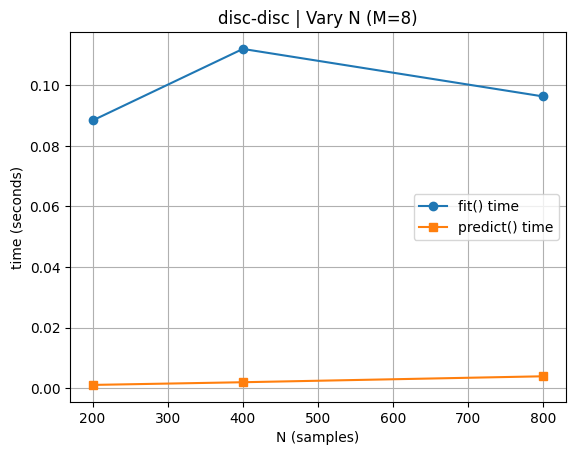

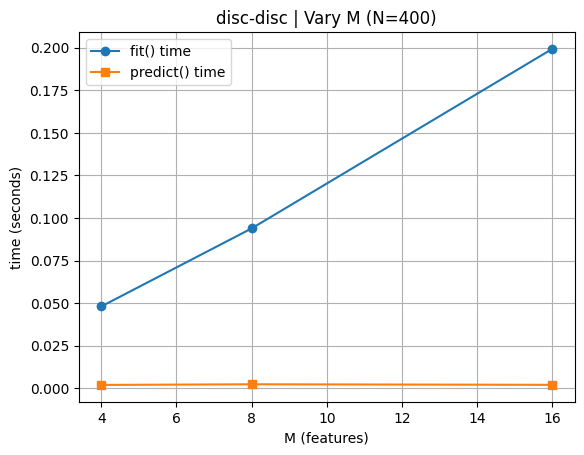

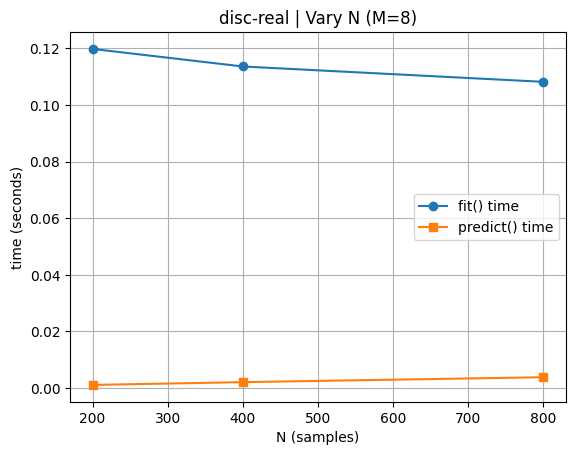

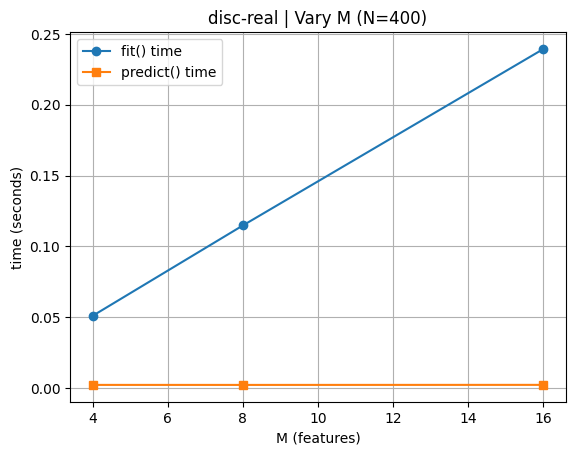

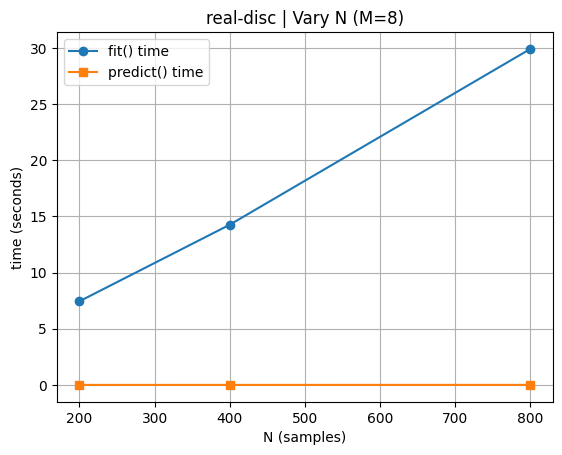

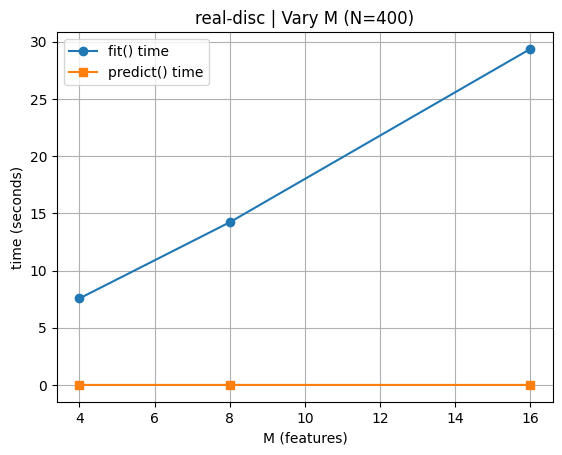

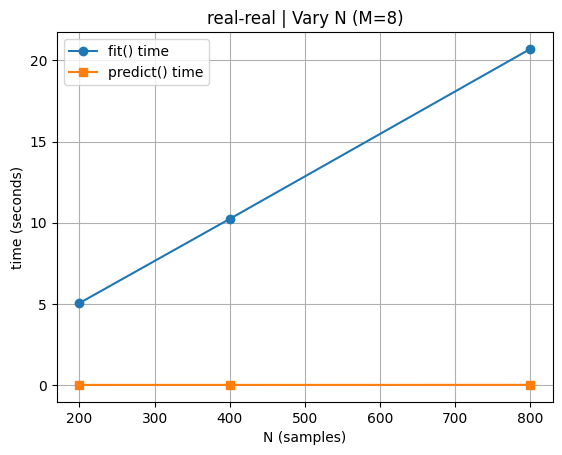

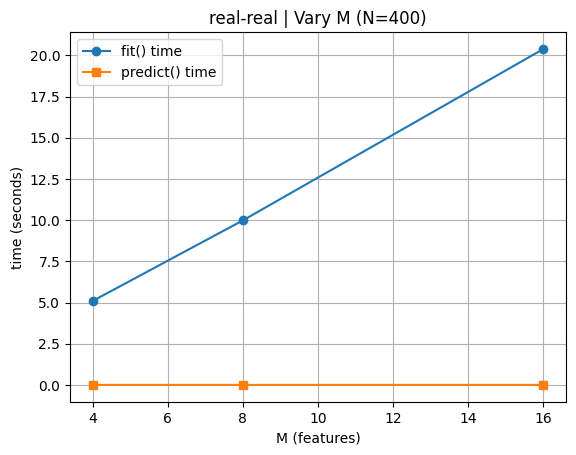

In [15]:
import time
from typing import Tuple, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tree.base import DecisionTree
from metrics import *

np.random.seed(42)
num_average_time = 100


# Generating the random data

def make_data_discrete_features(N: int, M: int, K: int = 2) -> pd.DataFrame:
    """Generate binary (0/1) features with shape (N, M)."""
    X = pd.DataFrame(np.random.randint(0, 2, size=(N, M)),
                     columns=[f"f{i}" for i in range(M)])
    return X

def make_data_real_features(N: int, M: int) -> pd.DataFrame:
    """Generate real-valued features from N(0,1)."""
    X = pd.DataFrame(np.random.randn(N, M),
                     columns=[f"x{i}" for i in range(M)])
    return X

def make_targets_discrete_from_binary(X: pd.DataFrame, K: int = 2) -> pd.Series:
    """Generate classification labels from binary features."""
    N, M = X.shape
    w = np.array([2.0, -1.5, 1.0, 1.0, -0.5][:min(5, M)])
    s = (X.iloc[:, :len(w)].values @ w)
    if K == 2:
        y = (s > np.median(s)).astype(int)
    else:
        qs = np.quantile(s, np.linspace(0, 1, K + 1))
        y = np.digitize(s, qs[1:-1])
    return pd.Series(y, dtype="category")

def make_targets_discrete_from_real(X: pd.DataFrame, K: int = 3) -> pd.Series:
    """Generate classification labels from real features."""
    N, M = X.shape
    w = np.random.randn(M)
    s = X.values @ w + 0.25 * np.random.randn(N)
    qs = np.quantile(s, np.linspace(0, 1, K + 1))
    y = np.digitize(s, qs[1:-1])
    return pd.Series(y, dtype="category")

def make_targets_real_from_binary(X: pd.DataFrame) -> pd.Series:
    """Generate regression targets from binary features."""
    N, M = X.shape
    w = np.array([1.5, -2.0, 0.75, 1.0, -0.5][:min(5, M)])
    mu = (X.iloc[:, :len(w)].values @ w)
    y = mu + 0.5 * np.random.randn(N)
    return pd.Series(y.astype(float))

def make_targets_real_from_real(X: pd.DataFrame) -> pd.Series:
    """Generate regression targets from real features."""
    N, M = X.shape
    w = np.linspace(1, 2, M)
    y = (X.values @ w) + 0.5 * np.random.randn(N)
    return pd.Series(y.astype(float))



# Definig the timing utilities

def time_fit_predict(tree: DecisionTree, X_train: pd.DataFrame,
                     y_train: pd.Series, X_test: pd.DataFrame,
                     reps: int = 5) -> Tuple[float, float]:
    """Return average fit and predict time over `reps` runs."""
    fit_times, pred_times = [], []
    for _ in range(reps):
        t0 = time.perf_counter()
        tree.fit(X_train, y_train)
        t1 = time.perf_counter()

        _ = tree.predict(X_test)
        t2 = time.perf_counter()

        fit_times.append(t1 - t0)
        pred_times.append(t2 - t1)

    return float(np.mean(fit_times)), float(np.mean(pred_times))


def run_sweeps(N_list: List[int], M_list: List[int],
               reps: int = 5, max_depth: int = 5) -> Dict[str, dict]:
    """
    Run timing sweeps for all 4 cases:
      A) discrete features, discrete output
      B) discrete features, real output
      C) real features, discrete output
      D) real features, real output
    """
    results = {"disc-disc": {}, "disc-real": {}, "real-disc": {}, "real-real": {}}
    M_fixed = M_list[len(M_list)//2]
    N_fixed = N_list[len(N_list)//2]

# Varying the samples N keeping the feature M fixed

    def _do_case(case_name: str, makeX, makeY, criterion: str):
        fitN, predN = [], []
        for N in N_list:
            X, y = makeX(N, M_fixed), makeY(makeX(N, M_fixed))
            n_train = max(1, int(0.8 * N))
            Xtr, Xte, ytr, yte = X.iloc[:n_train], X.iloc[n_train:], y.iloc[:n_train], y.iloc[n_train:]
            tree = DecisionTree(criterion=criterion, max_depth=max_depth)
            f, p = time_fit_predict(tree, Xtr, ytr, Xte, reps=reps)
            fitN.append(f); predN.append(p)

# Varying the features M keeping the samples N fixed
        fitM, predM = [], []
        for M in M_list:
            X, y = makeX(N_fixed, M), makeY(makeX(N_fixed, M))
            n_train = max(1, int(0.8 * N_fixed))
            Xtr, Xte, ytr, yte = X.iloc[:n_train], X.iloc[n_train:], y.iloc[:n_train], y.iloc[n_train:]
            tree = DecisionTree(criterion=criterion, max_depth=max_depth)
            f, p = time_fit_predict(tree, Xtr, ytr, Xte, reps=reps)
            fitM.append(f); predM.append(p)

        results[case_name]["vary_N"] = {"N": N_list, "fit": fitN, "pred": predN, "M_fixed": M_fixed}
        results[case_name]["vary_M"] = {"M": M_list, "fit": fitM, "pred": predM, "N_fixed": N_fixed}

# Case 1: Discrete Input, Discrete Output
    _do_case("disc-disc",
             makeX=lambda N, M: make_data_discrete_features(N, M),
             makeY=lambda X: make_targets_discrete_from_binary(X, K=2),
             criterion="information_gain")

# Case 2: Discrete Input, Real Output
    _do_case("disc-real",
             makeX=lambda N, M: make_data_discrete_features(N, M),
             makeY=make_targets_real_from_binary,
             criterion="information_gain")

# Case 3: Real Input, Discrete Output
    _do_case("real-disc",
             makeX=lambda N, M: make_data_real_features(N, M),
             makeY=lambda X: make_targets_discrete_from_real(X, K=3),
             criterion="gini_index")

# Case 4: Real Input, Real Output
    _do_case("real-real",
             makeX=lambda N, M: make_data_real_features(N, M),
             makeY=make_targets_real_from_real,
             criterion="information_gain")

    return results



# Plotting the time analysis data

def plot_times(results: Dict[str, dict], save_prefix: str = None):
    """Plot fit & predict times vs N and M for each case."""
# Varying the samples N
    for case, bundle in results.items():
        N, fit, pred, M_fixed = bundle["vary_N"]["N"], bundle["vary_N"]["fit"], bundle["vary_N"]["pred"], bundle["vary_N"]["M_fixed"]
        plt.figure()
        plt.plot(N, fit, marker="o", label="fit() time")
        plt.plot(N, pred, marker="s", label="predict() time")
        plt.xlabel("N (samples)")
        plt.ylabel("time (seconds)")
        plt.title(f"{case} | Vary N (M={M_fixed})")
        plt.legend(); plt.grid(True)
        if save_prefix:
            plt.savefig(f"{save_prefix}_{case}_varyN.png", bbox_inches="tight", dpi=160)
        plt.show()

# Varying the features M
        M, fit, pred, N_fixed = bundle["vary_M"]["M"], bundle["vary_M"]["fit"], bundle["vary_M"]["pred"], bundle["vary_M"]["N_fixed"]
        plt.figure()
        plt.plot(M, fit, marker="o", label="fit() time")
        plt.plot(M, pred, marker="s", label="predict() time")
        plt.xlabel("M (features)")
        plt.ylabel("time (seconds)")
        plt.title(f"{case} | Vary M (N={N_fixed})")
        plt.legend(); plt.grid(True)
        if save_prefix:
            plt.savefig(f"{save_prefix}_{case}_varyM.png", bbox_inches="tight", dpi=160)
        plt.show()


def print_theory_cheatsheet():
    """Print standard time complexity formulas for decision trees."""
    txt = """
== Theoretical Time Complexity (coarse) ==
Let N = samples, M = features, d = depth, and T = #nodes (~O(2^d) worst-case).

Training (per node):
  • Discrete features: O(MN)
  • Numeric features: O(M N log N)

Overall training:
  • O(T * M N) (discrete)
  • O(T * M N log N) (numeric)

Prediction:
  • O(d) per sample → O(N_test * d)

Empirical expectation:
  • fit() vs N: roughly linear (steeper for numeric features due to log N).
  • fit() vs M: roughly linear.
  • predict() vs N_test: linear; vs M: weak dependence.
"""
    print(txt)
if __name__ == "__main__":

    N_list = [200, 400, 800]
    M_list = [4, 8, 16]
    reps = 2
    max_depth = 4

    print_theory_cheatsheet()

    def run_sweeps_fast(N_list, M_list, reps, max_depth):
        results = {
            "disc-disc": {}, "disc-real": {}, "real-disc": {}, "real-real": {}
        }
        M_fixed = M_list[len(M_list)//2]
        N_fixed = N_list[len(N_list)//2]

        def _do_case(tag, makeX, makeY, criterion):
            print(f"\n== Running case: {tag} ==")

            fitN, predN = [], []
            for N in N_list:
                print(f"  vary N: N={N}, M={M_fixed}", flush=True)
                X = makeX(N, M_fixed); y = makeY(X)
                ntr = max(1, int(0.8*N))
                Xtr, Xte = X.iloc[:ntr], X.iloc[ntr:]; ytr, yte = y.iloc[:ntr], y.iloc[ntr:]
                tree = DecisionTree(criterion=criterion, max_depth=max_depth, one_hot_categoricals=False)
                f, p = time_fit_predict(tree, Xtr, ytr, Xte, reps=reps)
                fitN.append(f); predN.append(p)


            fitM, predM = [], []
            for M in M_list:
                print(f"  vary M: N={N_fixed}, M={M}", flush=True)
                X = makeX(N_fixed, M); y = makeY(X)
                ntr = max(1, int(0.8*N_fixed))
                Xtr, Xte = X.iloc[:ntr], X.iloc[ntr:]; ytr, yte = y.iloc[:ntr], y.iloc[ntr:]
                tree = DecisionTree(criterion=criterion, max_depth=max_depth, one_hot_categoricals=False)
                f, p = time_fit_predict(tree, Xtr, ytr, Xte, reps=reps)
                fitM.append(f); predM.append(p)

            results[tag]["vary_N"] = {"N": N_list, "fit": fitN, "pred": predN, "M_fixed": M_fixed}
            results[tag]["vary_M"] = {"M": M_list, "fit": fitM, "pred": predM, "N_fixed": N_fixed}

# Case 1: Discrete Input, Discrete Output
        _do_case("disc-disc",
                 makeX=lambda N, M: make_data_discrete_features(N, M),
                 makeY=lambda X: make_targets_discrete_from_binary(X, K=2),
                 criterion="information_gain")

# Case 2: Discrete Input, Real Output
        _do_case("disc-real",
                 makeX=lambda N, M: make_data_discrete_features(N, M),
                 makeY=make_targets_real_from_binary,
                 criterion="information_gain")

# Case 3: Real Input, Discrete Output
        _do_case("real-disc",
                 makeX=lambda N, M: make_data_real_features(N, M),
                 makeY=lambda X: make_targets_discrete_from_real(X, K=3),
                 criterion="gini_index")

# Case 4: Real Input, Real Output
        _do_case("real-real",
                 makeX=lambda N, M: make_data_real_features(N, M),
                 makeY=make_targets_real_from_real,
                 criterion="information_gain")

        return results

    results = run_sweeps_fast(N_list, M_list, reps=reps, max_depth=max_depth)
    plot_times(results, save_prefix="dt_runtime_fast")


# **Observations for Question 4**

We studied the runtime scaling of our Decision Tree implementation for all four cases:

1. **Discrete → Discrete (Classification with binary features)**
   - Fit time increases **linearly with number of features (M)**.  
   - Fit time also increases with number of samples (N), but slope is smaller compared to feature scaling.  
   - Predict time is negligible (almost flat), consistent with O(d) complexity.

2. **Discrete → Real (Regression with binary features)**
   - Similar trend as above: fit time grows roughly **linearly with M and N**.  
   - Predict time remains near-zero and does not scale strongly with dataset size.  

3. **Real → Discrete (Classification with real features)**
   - Fit time grows **sharply with both N and M**, much steeper than in discrete cases.  
   - This matches the theoretical **O(M N log N)** cost for real-valued splits.  
   - Prediction time is again almost constant.

4. **Real → Real (Regression with real features)**
   - Fit time also grows strongly with N and M, showing similar steepness as real-disc.  
   - This confirms that numeric features dominate cost due to sorting + threshold evaluation.  
   - Prediction cost is minimal.


### Overall Observations
- **Fit time dominates** over prediction time in all experiments.  
- **Discrete features**: runtime scales almost linearly with N and M.  
- **Real features**: runtime scales faster (close to O(N log N)), especially as both N and M grow.  
- **Prediction is cheap**: nearly constant time per sample (O(d)), confirming theoretical expectations.  
- Results are consistent with the **theoretical complexity cheatsheet**.
